In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np 
from typing import List, Tuple
from flwr.common import Metrics
import ray
#https://medium.com/mlearning-ai/evaluating-federated-learning-from-felt-labs-on-mnist-dataset-cbe081b28786
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()


2024-02-11 11:59:24.477492: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-11 11:59:26.139256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 11:59:26.139366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 11:59:26.296044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 11:59:26.901816: I tensorflow/core/platform/cpu_feature_guar

In [2]:
ray.init()

2024-02-11 11:59:37,894	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.12
Ray version:,2.9.2
Dashboard:,http://127.0.0.1:8265


# Data Processing

In [3]:
def getCifarData():
    (traindataset,testDataset),datasetinfo = tfds.load(
        'cifar10',
        split=['train','test'],
        shuffle_files= True,
        as_supervised= True,
        with_info= True
    )
    return traindataset,testDataset,datasetinfo

In [4]:
def dataset_to_numpy(dataset):
    features = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        features.append(image)
        labels.append(label)
    return np.array(features), np.array(labels)

def Splitset(intrain,intest):
    Train_images, Train_label = dataset_to_numpy(intrain)
    Test_images, Test_label = dataset_to_numpy(intest)
    return  Train_images, Train_label,Test_images, Test_label

def datanorm(data):
    return data/255 

In [5]:
trainset,testset, info = getCifarData()
Train_images, Train_label,Test_images, Test_label = Splitset(trainset,testset)
Train_images_n = datanorm(Train_images)
Test_images_n = datanorm(Test_images)


2024-02-11 11:59:38.768583: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-11 11:59:38.768761: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-11 11:59:38.768820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

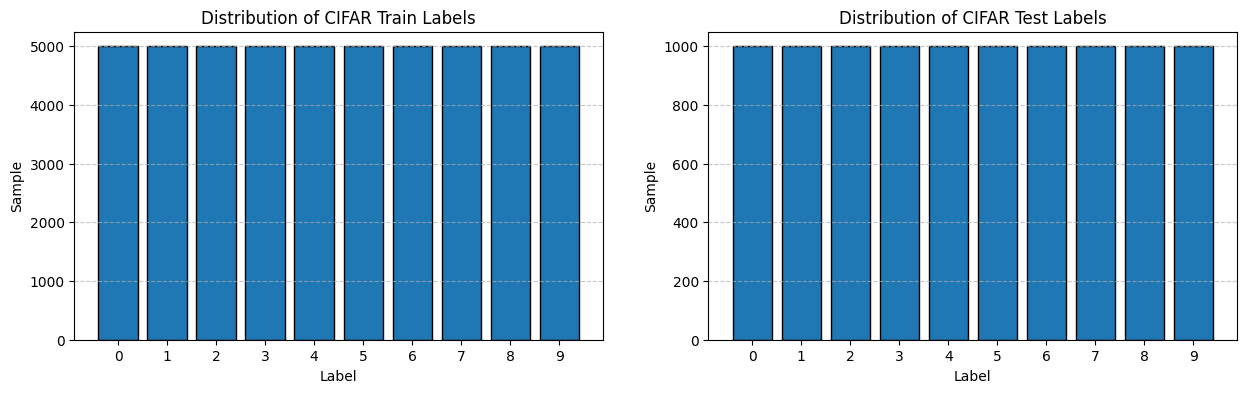

In [6]:
fig_1,axs_1 = plt.subplots(1,2,figsize = (15,4))
axs_1[0].hist(Train_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[0].set_title('Distribution of CIFAR Train Labels')
axs_1[0].set_xlabel('Label')
axs_1[0].set_ylabel('Sample')
axs_1[0].set_xticks(range(10))  # Digits 0 to 9
axs_1[0].grid(axis='y', linestyle='--', alpha=0.7)

axs_1[1].hist(Test_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[1].set_title('Distribution of CIFAR Test Labels')
axs_1[1].set_xlabel('Label')
axs_1[1].set_ylabel('Sample')
axs_1[1].set_xticks(range(10))  # Digits 0 to 9
axs_1[1].grid(axis='y', linestyle='--', alpha=0.7)


# Partition DataSet

In [7]:
def split_into_partition(data, labels, num_partitions):
    # Combine data and labels
    combined_data = list(zip(data, labels))
    np.random.shuffle(combined_data)  # Shuffle the combined data randomly

    partitions = [[] for _ in range(num_partitions)]
    store_label = np.unique(labels).tolist()
    counter = 0
    count = 0
    # Iterate over unique labels to efficiently distribute them across partitions
    while store_label:
        random_choice = np.random.choice(store_label)

        # Extract data and labels for the selected class
        class_data = [item[0] for item in combined_data if item[1] == random_choice]
        class_labels = [random_choice] * len(class_data)

        # Distribute the class data evenly among partitions
        modnum = len(np.unique(labels)) // num_partitions

        if counter == (num_partitions - 1):
            partitions[counter].extend(list(zip(class_data, class_labels)))
        elif count <= modnum:
            # Extend the selected partition with the data and labels
            count+=1
            partitions[counter].extend(list(zip(class_data, class_labels)))
            if count == modnum:
                counter += 1
                count=0


        store_label.remove(random_choice)

   # Separate data and labels after partitioning
    data_partitions = [np.array(list(zip(*partition))[0]) if partition else np.array([]) for partition in partitions]
    label_partitions = [np.array(list(zip(*partition))[1]) if partition else np.array([]) for partition in partitions]


    return data_partitions, label_partitions

In [8]:
NumOfPartition = 2
train_image_part,train_label_part = split_into_partition(Train_images_n,Train_label,NumOfPartition)

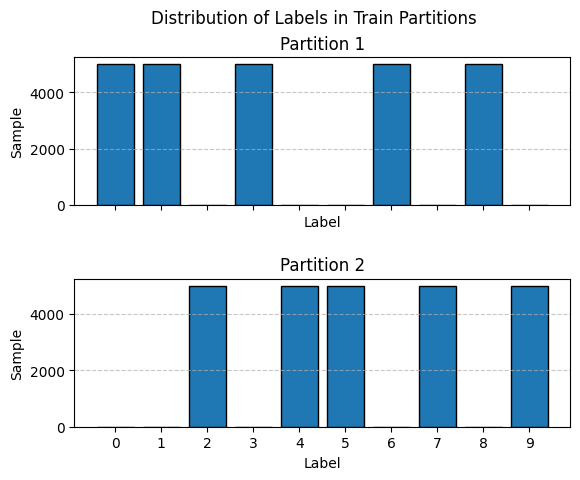

In [9]:
# Plot histogram for each partition
fig, axs = plt.subplots(NumOfPartition, sharex=True, sharey=True)

for i, partition in enumerate(train_label_part):
    axs[i].hist(partition, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black')
    axs[i].set_title(f'Partition {i + 1}')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Sample')
    axs[i].set_xticks(range(10))
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Labels in Train Partitions')
plt.show()

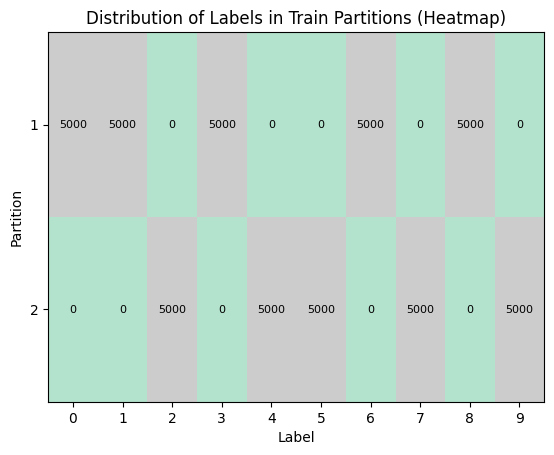

In [10]:
# Create an array to store the histogram data for each partition
hist_data = [np.histogram(partition, bins=range(11))[0] for partition in train_label_part]

# Plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(hist_data, cmap='Pastel2',aspect='auto', interpolation='none')

# Add annotations
for i in range(len(train_label_part)):
    for j in range(10):
        text = ax.text(j, i, hist_data[i][j], ha='center', va='center', color='black', fontsize=8)

# Set labels and ticks
ax.set_title('Distribution of Labels in Train Partitions (Heatmap)')
ax.set_xlabel('Label')
ax.set_ylabel('Partition')
ax.set_xticks(range(10))
ax.set_yticks(range(len(train_label_part)))
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(1, len(train_label_part) + 1))

# Add colorbar
plt.colorbar(im, ax=ax).remove()

plt.show()

In [11]:
def customCNNModel():
    model = keras.Sequential()
    # First convolutional layer
    model.add(keras.layers.Conv2D(20, (3, 3), activation='relu', input_shape=(32,32,3)))
    model.add(keras.layers.MaxPooling2D(pool_size=(3, 3),strides=(2,2)))
    # Flatten the output before the fully connected layers
    model.add(keras.layers.Flatten())
    # Fully connected layers
    model.add(keras.layers.Dense(100, activation='relu'))       
    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss= "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Client

In [12]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, train_x,train_y,val_x,val_y, model) -> None:
        super().__init__()
        self.train_feature_set = train_x
        self.train_label_set = train_y
        self.val_feature_set = val_x
        self.val_label_set = val_y
        self.model = model
        
    def get_parameters(self, config):
        return self.model.get_weights()
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print(f"round :{config['current_round']}")
        print(f"Train :{len(self.train_feature_set)}")
        print(f"Test :{len(self.val_feature_set)}")

        # Train the returned model
        TrainHistory = self.model.fit(x=self.train_feature_set, 
                                 y=self.train_label_set,
                                 verbose=2, 
                                 batch_size=config['batch_size'],
                                 epochs=config['local_epochs'],
                                 validation_data =(self.val_feature_set,self.val_label_set)
                                 )
        result ={
                "loss": TrainHistory.history['loss'][-1],
                "accuracy": round(TrainHistory.history['accuracy'][-1]*100,2),
                "val_loss" : TrainHistory.history['val_loss'][-1],
                "val_accuracy"  : round(TrainHistory.history["val_accuracy"][-1]*100,2),
        }

        print("Client Train and validate Done!!!")       
        # Send local model to server to do aggreation
        return self.model.get_weights(), len(self.train_feature_set),result

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # Test Global model
        loss, accuracy = self.model.evaluate(self.val_feature_set,
                                        self.val_label_set,
                                        batch_size=config['batch_size'],
                                        verbose=2)
        print("Global Validate Done!!!")       
        return loss, len(self.val_feature_set), {"accuracy": round(float(accuracy*100),2)}


def generate_client_fn(train_x,train_y,val_x,val_y, model):
    """Return a function to construct a FlowerClient."""

    def client_fn(cid: str):
        print
        return FlowerClient(train_x[int(cid)],train_y[int(cid)],val_x,val_y,model)
    return client_fn


# Server

In [13]:
# config for Client using Server side
def fit_config(server_round: int):
    """Return training configuration dict for each round."""
    config = {
        "batch_size": 32,
        "current_round": server_round,
        "local_epochs": 50,
    }
    return config

def evalute_config(server_round: int):
    """Return test configuration dict for each round."""
    config = {
        "batch_size": 1,
        "current_round": server_round,
    }
    return config

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def fit_average(metric):
    examples = [num_examples for num_examples, _ in metric]
    trainacc = [num_examples * m["accuracy"] for num_examples, m in metric]
    valacc = [num_examples * m["val_accuracy"] for num_examples, m in metric]
    
    return { "example": sum(examples),
            "accuracy": sum(trainacc) / sum(examples),
            "valacc": sum(valacc) / sum(examples)
            }





In [14]:
Fedavgconfig = fl.server.strategy.FedAvg(on_fit_config_fn=fit_config,
                                         on_evaluate_config_fn=evalute_config,
                                         evaluate_metrics_aggregation_fn=weighted_average,
                                         fit_metrics_aggregation_fn=fit_average,
                                         min_evaluate_clients= NumOfPartition,
                                         min_fit_clients=NumOfPartition,
                                         min_available_clients=NumOfPartition,
                                        )

# Simulation

In [15]:
globalmodel = customCNNModel()
clientfn = generate_client_fn(train_image_part,train_label_part,Test_images_n,Test_label,globalmodel)

In [16]:
history = fl.simulation.start_simulation(
        client_fn=clientfn,
        num_clients=NumOfPartition,
        config=fl.server.ServerConfig(num_rounds=10),
        strategy=Fedavgconfig,
        ray_init_args ={
            "include_dashboard": True, # we need this one for tracking,
        },
        actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth # <-- To be executed upon actor init.
    },
        client_resources = {'num_cpus': 8, 'num_gpus': 1}, # A Python dict specifying CPU/GPU resources
    )

INFO flwr 2024-02-11 11:59:48,961 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-11 11:59:52,117	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2024-02-11 11:59:52,867 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3036076032.0, 'CPU': 16.0, 'memory': 6072152064.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'node:192.168.1.100': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3036076032.0, 'CPU': 16.0, 'memory': 6072152064.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'node:192.168.1.100': 1.0}
INFO flwr 2024-02-11 11:59:52,868 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Opti

(DefaultActor pid=189857) round :1
(DefaultActor pid=189857) Train :25000
(DefaultActor pid=189857) Test :10000


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50


(DefaultActor pid=189857) 2024-02-11 11:59:56.198009: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
(DefaultActor pid=189857) 2024-02-11 11:59:57.071030: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
(DefaultActor pid=189857) 2024-02-11 11:59:57.736974: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
(DefaultActor pid=189857) 2024-02-11 11:59:58.006728: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc35c2f5cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
(DefaultActor pid=189857) 2024-02-11 11:59:58.006798: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
(DefaultActor pid=189857) 2024-02-11 11:59:58.017377: I tensorflow/compiler/mlir/tensorflow/uti

(DefaultActor pid=189857) 782/782 - 6s - loss: 0.8657 - accuracy: 0.6583 - val_loss: 6.2613 - val_accuracy: 0.3665 - 6s/epoch - 7ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.6466 - accuracy: 0.7587 - val_loss: 7.2355 - val_accuracy: 0.3831 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.5698 - accuracy: 0.7897 - val_loss: 7.3935 - val_accuracy: 0.3896 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.5175 - accuracy: 0.8091 - val_loss: 8.4090 - val_accuracy: 0.4029 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.4829 - accuracy: 0.8218 - val_loss: 8.2577 - val_accuracy: 0.3947 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.4421 - accuracy: 0.8378 - val_loss: 8.3895 - val_accuracy: 0.3999 - 2s/epoch - 2m

(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 1.0862 - accuracy: 0.5651 - val_loss: 6.6345 - val_accuracy: 0.3239 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.8737 - accuracy: 0.6629 - val_loss: 7.0496 - val_accuracy: 0.3384 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.7981 - accuracy: 0.6965 - val_loss: 8.0771 - val_accuracy: 0.3328 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.7450 - accuracy: 0.7192 - val_loss: 7.6648 - val_accuracy: 0.3460 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.7013 - accuracy: 0.7362 - val_loss: 9.1207 - val_accuracy: 0.3524 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.6706 - accuracy: 0.7460 - val_loss: 9.0612 -

DEBUG flwr 2024-02-11 12:02:37,800 | server.py:236 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:02:37,805 | server.py:173 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 1: strategy sampled 2 clients (out of 2)


(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0376 - accuracy: 0.9882 - val_loss: 38.2513 - val_accuracy: 0.3599 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Client Train and validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 3.5575 - accuracy: 0.3173 - 7s/epoch - 671us/step
(DefaultActor pid=189857) Global Validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-11 12:02:51,930 | server.py:187 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:02:51,930 | server.py:222 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 2)


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 3.5575 - accuracy: 0.3173 - 7s/epoch - 661us/step
(DefaultActor pid=189857) Global Validate Done!!!
(DefaultActor pid=189857) round :2
(DefaultActor pid=189857) Train :25000
(DefaultActor pid=189857) Test :10000


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.3052 - accuracy: 0.8911 - val_loss: 9.8696 - val_accuracy: 0.3672 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.1573 - accuracy: 0.9511 - val_loss: 11.7756 - val_accuracy: 0.3714 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.1105 - accuracy: 0.9682 - val_loss: 13.0211 - val_accuracy: 0.3693 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0876 - accuracy: 0.9753 - val_loss: 13.5047 - val_accuracy: 0.3727 - 1s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0829 - accuracy: 0.9761 - val_loss: 15.0179 - val_accuracy: 0.3670 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0856 - accuracy: 0.9746 - val_loss: 15.2

(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) round :2
(DefaultActor pid=189857) Train :25000
(DefaultActor pid=189857) Test :10000
(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.1968 - accuracy: 0.9322 - val_loss: 9.7403 - val_accuracy: 0.3998 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0941 - accuracy: 0.9704 - val_loss: 10.9953 - val_accuracy: 0.4050 - 1s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0738 - accuracy: 0.9776 - val_loss: 11.3373 - val_accuracy: 0.4055 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0530 - accuracy: 0.9854 - val_loss: 12.1483 - val_accuracy: 0.4027 - 1s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0604 - accuracy: 0.9812 - val_loss: 13.2405 - val_accuracy: 0.4019 - 2s/epoch - 2ms/step
(DefaultActor 

DEBUG flwr 2024-02-11 12:05:32,019 | server.py:236 | fit_round 2 received 2 results and 0 failures
DEBUG:flwr:fit_round 2 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:05:32,022 | server.py:173 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 2: strategy sampled 2 clients (out of 2)


(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0261 - accuracy: 0.9923 - val_loss: 33.2730 - val_accuracy: 0.4006 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Client Train and validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) 10000/10000 - 6s - loss: 4.9954 - accuracy: 0.3631 - 6s/epoch - 647us/step
(DefaultActor pid=189857) Global Validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-11 12:05:45,676 | server.py:187 | evaluate_round 2 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:05:45,677 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 2)
(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 

(DefaultActor pid=189857) 10000/10000 - 7s - loss: 4.9954 - accuracy: 0.3631 - 7s/epoch - 653us/step
(DefaultActor pid=189857) Global Validate Done!!!


(DefaultActor pid=189857) round :3
(DefaultActor pid=189857) Train :25000
(DefaultActor pid=189857) Test :10000
(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.5656 - accuracy: 0.8293 - val_loss: 15.3031 - val_accuracy: 0.3580 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.1532 - accuracy: 0.9462 - val_loss: 17.7005 - val_accuracy: 0.3601 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0581 - accuracy: 0.9819 - val_loss: 20.5513 - val_accuracy: 0.3663 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0240 - accuracy: 0.9950 - val_loss: 20.8465 - val_accuracy: 0.3660 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0285 - accuracy: 0.9927 - val_loss: 20.8705 - val_accuracy: 0.3589 - 2s/epoch - 2ms/step
(DefaultActor

(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) round :3
(DefaultActor pid=189857) Train :25000
(DefaultActor pid=189857) Test :10000
(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 3s - loss: 0.3439 - accuracy: 0.9008 - val_loss: 16.8489 - val_accuracy: 0.3978 - 3s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0741 - accuracy: 0.9747 - val_loss: 17.9538 - val_accuracy: 0.3979 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0268 - accuracy: 0.9916 - val_loss: 19.7276 - val_accuracy: 0.4023 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0163 - accuracy: 0.9957 - val_loss: 20.8803 - val_accuracy: 0.4005 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0323 - accuracy: 0.9895 - val_loss: 20.1748 - val_accuracy: 0.3981 - 2s/epoch - 2ms/step
(DefaultActor

DEBUG flwr 2024-02-11 12:08:27,707 | server.py:236 | fit_round 3 received 2 results and 0 failures
DEBUG:flwr:fit_round 3 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:08:27,710 | server.py:173 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 3: strategy sampled 2 clients (out of 2)


(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0087 - accuracy: 0.9974 - val_loss: 38.3808 - val_accuracy: 0.4007 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Client Train and validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 6.3515 - accuracy: 0.3927 - 7s/epoch - 655us/step
(DefaultActor pid=189857) Global Validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-11 12:08:41,637 | server.py:187 | evaluate_round 3 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:08:41,638 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 4: strategy sampled 2 clients (out of 2)


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 6.3515 - accuracy: 0.3927 - 7s/epoch - 658us/step
(DefaultActor pid=189857) Global Validate Done!!!
(DefaultActor pid=189857) round :4
(DefaultActor pid=189857) Train :25000
(DefaultActor pid=189857) Test :10000


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.4621 - accuracy: 0.8842 - val_loss: 21.5327 - val_accuracy: 0.3483 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0805 - accuracy: 0.9729 - val_loss: 25.6760 - val_accuracy: 0.3587 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0231 - accuracy: 0.9929 - val_loss: 26.2447 - val_accuracy: 0.3611 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0117 - accuracy: 0.9977 - val_loss: 26.9137 - val_accuracy: 0.3618 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0306 - accuracy: 0.9912 - val_loss: 25.3937 - val_accuracy: 0.3581 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0304 - accuracy: 0.9897 - val_loss: 25.

(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.2523 - accuracy: 0.9370 - val_loss: 24.2047 - val_accuracy: 0.3975 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0355 - accuracy: 0.9881 - val_loss: 26.4557 - val_accuracy: 0.3995 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0182 - accuracy: 0.9938 - val_loss: 25.8370 - val_accuracy: 0.3985 - 1s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0204 - accuracy: 0.9933 - val_loss: 27.8239 - val_accuracy: 0.3999 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0158 - accuracy: 0.9946 - val_loss: 28.2693 - val_accuracy: 0.3977 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0254 - accuracy: 0.9911 - val_loss: 28.

DEBUG flwr 2024-02-11 12:11:24,530 | server.py:236 | fit_round 4 received 2 results and 0 failures
DEBUG:flwr:fit_round 4 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:11:24,533 | server.py:173 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 4: strategy sampled 2 clients (out of 2)
(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 

(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0123 - accuracy: 0.9961 - val_loss: 44.3899 - val_accuracy: 0.4042 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Client Train and validate Done!!!


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 7.3052 - accuracy: 0.4114 - 7s/epoch - 668us/step
(DefaultActor pid=189857) Global Validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-11 12:11:38,805 | server.py:187 | evaluate_round 4 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:11:38,806 | server.py:222 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 5: strategy sampled 2 clients (out of 2)


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 7.3052 - accuracy: 0.4114 - 7s/epoch - 680us/step
(DefaultActor pid=189857) Global Validate Done!!!
(DefaultActor pid=189857) round :5
(DefaultActor pid=189857) Train :25000
(DefaultActor pid=189857) Test :10000


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.3546 - accuracy: 0.9168 - val_loss: 26.6939 - val_accuracy: 0.3534 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0394 - accuracy: 0.9859 - val_loss: 28.7084 - val_accuracy: 0.3609 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0106 - accuracy: 0.9972 - val_loss: 29.1780 - val_accuracy: 0.3646 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0036 - accuracy: 0.9996 - val_loss: 29.3266 - val_accuracy: 0.3633 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0039 - accuracy: 0.9995 - val_loss: 30.8400 - val_accuracy: 0.3641 - 1s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0455 - accuracy: 0.9858 - val_loss: 32.

(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.2151 - accuracy: 0.9498 - val_loss: 27.7799 - val_accuracy: 0.3970 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0249 - accuracy: 0.9913 - val_loss: 29.1442 - val_accuracy: 0.4031 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0071 - accuracy: 0.9976 - val_loss: 31.3548 - val_accuracy: 0.4037 - 1s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0110 - accuracy: 0.9963 - val_loss: 30.1492 - val_accuracy: 0.4009 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0318 - accuracy: 0.9893 - val_loss: 29.1499 - val_accuracy: 0.3934 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0107 - accuracy: 0.9966 - val_loss: 34.

DEBUG flwr 2024-02-11 12:14:21,427 | server.py:236 | fit_round 5 received 2 results and 0 failures
DEBUG:flwr:fit_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:14:21,430 | server.py:173 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 5: strategy sampled 2 clients (out of 2)


(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0184 - accuracy: 0.9950 - val_loss: 50.3340 - val_accuracy: 0.4040 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Client Train and validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 8.5521 - accuracy: 0.4119 - 7s/epoch - 655us/step
(DefaultActor pid=189857) Global Validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-11 12:14:35,361 | server.py:187 | evaluate_round 5 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:14:35,362 | server.py:222 | fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 6: strategy sampled 2 clients (out of 2)
(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 8.5521 - accuracy: 0.4119 - 7s/epoch - 658us/step
(DefaultActor pid=189857) Global Validate Done!!!
(DefaultActor pid=189857) round :6
(DefaultActor pid=189857) Train :25000
(DefaultActor pid=189857) Test :10000
(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.2809 - accuracy: 0.9384 - val_loss: 31.4727 - val_accuracy: 0.3532 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0227 - accuracy: 0.9923 - val_loss: 32.6269 - val_accuracy: 0.3561 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0093 - accuracy: 0.9972 - val_loss: 34.1285 - val_accuracy: 0.3582 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0043 - accuracy: 0.9991 - val_loss: 33.9875 - val_accuracy: 0.3585 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.1817 - accuracy: 0.9607 - val_loss: 33.2235 - val_accuracy: 0.3972 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0169 - accuracy: 0.9944 - val_loss: 34.8907 - val_accuracy: 0.3967 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0112 - accuracy: 0.9962 - val_loss: 35.3413 - val_accuracy: 0.3984 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0123 - accuracy: 0.9963 - val_loss: 33.8296 - val_accuracy: 0.3969 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0128 - accuracy: 0.9958 - val_loss: 37.3312 - val_accuracy: 0.4008 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0264 - accuracy: 0.9919 - val_loss: 36.

DEBUG flwr 2024-02-11 12:17:18,922 | server.py:236 | fit_round 6 received 2 results and 0 failures
DEBUG:flwr:fit_round 6 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:17:18,925 | server.py:173 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 6: strategy sampled 2 clients (out of 2)


(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0087 - accuracy: 0.9977 - val_loss: 57.2540 - val_accuracy: 0.3955 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Client Train and validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 9.7563 - accuracy: 0.4162 - 7s/epoch - 672us/step
(DefaultActor pid=189857) Global Validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-11 12:17:33,125 | server.py:187 | evaluate_round 6 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:17:33,126 | server.py:222 | fit_round 7: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 7: strategy sampled 2 clients (out of 2)
(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 9.7563 - accuracy: 0.4162 - 7s/epoch - 668us/step
(DefaultActor pid=189857) Global Validate Done!!!
(DefaultActor pid=189857) round :7
(DefaultActor pid=189857) Train :25000
(DefaultActor pid=189857) Test :10000
(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.1568 - accuracy: 0.9679 - val_loss: 38.8785 - val_accuracy: 0.3965 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0119 - accuracy: 0.9967 - val_loss: 39.7825 - val_accuracy: 0.3970 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0068 - accuracy: 0.9980 - val_loss: 42.2261 - val_accuracy: 0.3994 - 1s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0094 - accuracy: 0.9974 - val_loss: 42.9330 - val_accuracy: 0.3953 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.2507 - accuracy: 0.9501 - val_loss: 34.4937 - val_accuracy: 0.3570 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0172 - accuracy: 0.9942 - val_loss: 37.0999 - val_accuracy: 0.3603 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0055 - accuracy: 0.9984 - val_loss: 37.4954 - val_accuracy: 0.3590 - 1s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0020 - accuracy: 0.9996 - val_loss: 36.3818 - val_accuracy: 0.3572 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0329 - accuracy: 0.9901 - val_loss: 38.8670 - val_accuracy: 0.3541 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0150 - accuracy: 0.9949 - val_loss: 42.

DEBUG flwr 2024-02-11 12:20:15,820 | server.py:236 | fit_round 7 received 2 results and 0 failures
DEBUG:flwr:fit_round 7 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:20:15,823 | server.py:173 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 7: strategy sampled 2 clients (out of 2)
(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0139 - accuracy: 0.9966 - val_loss: 62.4368 - val_accuracy: 0.3623 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Client Train and validate Done!!!
(DefaultActor pid=189857) 10000/10000 - 7s - loss: 13.5239 - accuracy: 0.4081 - 7s/epoch - 653us/step
(DefaultActor pid=189857) Global Validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-11 12:20:29,866 | server.py:187 | evaluate_round 7 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:20:29,867 | server.py:222 | fit_round 8: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 8: strategy sampled 2 clients (out of 2)


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 13.5239 - accuracy: 0.4081 - 7s/epoch - 671us/step
(DefaultActor pid=189857) Global Validate Done!!!
(DefaultActor pid=189857) round :8
(DefaultActor pid=189857) Train :25000
(DefaultActor pid=189857) Test :10000


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.1072 - accuracy: 0.9779 - val_loss: 43.3892 - val_accuracy: 0.3543 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0098 - accuracy: 0.9970 - val_loss: 42.2497 - val_accuracy: 0.3571 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0036 - accuracy: 0.9990 - val_loss: 45.1459 - val_accuracy: 0.3587 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0031 - accuracy: 0.9990 - val_loss: 44.0770 - val_accuracy: 0.3562 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0271 - accuracy: 0.9924 - val_loss: 47.7017 - val_accuracy: 0.3590 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0111 - accuracy: 0.9967 - val_loss: 44.

(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.2610 - accuracy: 0.9632 - val_loss: 43.9473 - val_accuracy: 0.3946 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0164 - accuracy: 0.9948 - val_loss: 42.2110 - val_accuracy: 0.3933 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0069 - accuracy: 0.9980 - val_loss: 40.3681 - val_accuracy: 0.3952 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0073 - accuracy: 0.9978 - val_loss: 41.8821 - val_accuracy: 0.3927 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0230 - accuracy: 0.9926 - val_loss: 47.5627 - val_accuracy: 0.3948 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0147 - accuracy: 0.9956 - val_loss: 47.

DEBUG flwr 2024-02-11 12:23:13,704 | server.py:236 | fit_round 8 received 2 results and 0 failures
DEBUG:flwr:fit_round 8 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:23:13,708 | server.py:173 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 8: strategy sampled 2 clients (out of 2)


(DefaultActor pid=189857) 782/782 - 2s - loss: 1.7809e-06 - accuracy: 1.0000 - val_loss: 65.6560 - val_accuracy: 0.4052 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Client Train and validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 11.7440 - accuracy: 0.4222 - 7s/epoch - 666us/step
(DefaultActor pid=189857) Global Validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-11 12:23:27,958 | server.py:187 | evaluate_round 8 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:23:27,959 | server.py:222 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 9: strategy sampled 2 clients (out of 2)


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 11.7440 - accuracy: 0.4222 - 7s/epoch - 678us/step
(DefaultActor pid=189857) Global Validate Done!!!
(DefaultActor pid=189857) round :9
(DefaultActor pid=189857) Train :25000
(DefaultActor pid=189857) Test :10000


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.1778 - accuracy: 0.9706 - val_loss: 40.4778 - val_accuracy: 0.3568 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0091 - accuracy: 0.9970 - val_loss: 39.3042 - val_accuracy: 0.3550 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0048 - accuracy: 0.9984 - val_loss: 42.9732 - val_accuracy: 0.3514 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0215 - accuracy: 0.9932 - val_loss: 44.3685 - val_accuracy: 0.3530 - 1s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0146 - accuracy: 0.9955 - val_loss: 46.9016 - val_accuracy: 0.3513 - 1s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0106 - accuracy: 0.9966 - val_loss: 46.

(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.1198 - accuracy: 0.9807 - val_loss: 47.4357 - val_accuracy: 0.4006 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0086 - accuracy: 0.9973 - val_loss: 44.9157 - val_accuracy: 0.3957 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0035 - accuracy: 0.9990 - val_loss: 44.2285 - val_accuracy: 0.4005 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0120 - accuracy: 0.9965 - val_loss: 47.4539 - val_accuracy: 0.3985 - 1s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0131 - accuracy: 0.9962 - val_loss: 51.4116 - val_accuracy: 0.3960 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0146 - accuracy: 0.9958 - val_loss: 51.

DEBUG flwr 2024-02-11 12:26:11,312 | server.py:236 | fit_round 9 received 2 results and 0 failures
DEBUG:flwr:fit_round 9 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:26:11,317 | server.py:173 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 9: strategy sampled 2 clients (out of 2)
(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0055 - accuracy: 0.9986 - val_loss: 67.5896 - val_accuracy: 0.3994 - 1s/epoch - 2ms/step
(DefaultActor pid=189857) Client Train and validate Done!!!
(DefaultActor pid=189857) 10000/10000 - 7s - loss: 12.6219 - accuracy: 0.4241 - 7s/epoch - 668us/step
(DefaultActor pid=189857) Global Validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-11 12:26:25,514 | server.py:187 | evaluate_round 9 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:26:25,515 | server.py:222 | fit_round 10: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 10: strategy sampled 2 clients (out of 2)


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 12.6219 - accuracy: 0.4241 - 7s/epoch - 672us/step
(DefaultActor pid=189857) Global Validate Done!!!
(DefaultActor pid=189857) round :10
(DefaultActor pid=189857) Train :25000
(DefaultActor pid=189857) Test :10000


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.1943 - accuracy: 0.9685 - val_loss: 45.0714 - val_accuracy: 0.3548 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 0.0101 - accuracy: 0.9966 - val_loss: 43.3347 - val_accuracy: 0.3575 - 1s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0027 - accuracy: 0.9991 - val_loss: 45.9488 - val_accuracy: 0.3614 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0228 - accuracy: 0.9946 - val_loss: 45.9507 - val_accuracy: 0.3531 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0098 - accuracy: 0.9972 - val_loss: 48.7499 - val_accuracy: 0.3529 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 6/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0073 - accuracy: 0.9976 - val_loss: 52.

(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) round :10
(DefaultActor pid=189857) Train :25000
(DefaultActor pid=189857) Test :10000
(DefaultActor pid=189857) Epoch 1/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.1025 - accuracy: 0.9843 - val_loss: 49.3624 - val_accuracy: 0.3970 - 2s/epoch - 3ms/step
(DefaultActor pid=189857) Epoch 2/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0049 - accuracy: 0.9984 - val_loss: 48.9954 - val_accuracy: 0.3982 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 3/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0016 - accuracy: 0.9995 - val_loss: 51.2557 - val_accuracy: 0.3978 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 4/50
(DefaultActor pid=189857) 782/782 - 2s - loss: 2.9001e-04 - accuracy: 1.0000 - val_loss: 51.7866 - val_accuracy: 0.3983 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Epoch 5/50
(DefaultActor pid=189857) 782/782 - 1s - loss: 5.9993e-05 - accuracy: 1.0000 - val_loss: 51.9108 - val_accuracy: 0.3982 - 1s/epoch - 2ms/step
(Def

DEBUG flwr 2024-02-11 12:29:10,187 | server.py:236 | fit_round 10 received 2 results and 0 failures
DEBUG:flwr:fit_round 10 received 2 results and 0 failures
DEBUG flwr 2024-02-11 12:29:10,190 | server.py:173 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 10: strategy sampled 2 clients (out of 2)


(DefaultActor pid=189857) 782/782 - 2s - loss: 0.0071 - accuracy: 0.9981 - val_loss: 71.4255 - val_accuracy: 0.4000 - 2s/epoch - 2ms/step
(DefaultActor pid=189857) Client Train and validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 14.0757 - accuracy: 0.4292 - 7s/epoch - 658us/step
(DefaultActor pid=189857) Global Validate Done!!!


(DefaultActor pid=189857) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-11 12:29:24,024 | server.py:187 | evaluate_round 10 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 2 results and 0 failures
INFO flwr 2024-02-11 12:29:24,025 | server.py:153 | FL finished in 1769.2167063220004
INFO:flwr:FL finished in 1769.2167063220004
INFO flwr 2024-02-11 12:29:24,025 | app.py:226 | app_fit: losses_distributed [(1, 3.5574796199798584), (2, 4.995397090911865), (3, 6.351480960845947), (4, 7.305200099945068), (5, 8.55211353302002), (6, 9.756349563598633), (7, 13.523898124694824), (8, 11.744044303894043), (9, 12.621869087219238), (10, 14.075733184814453)]
INFO:flwr:app_fit: losses_distributed [(1, 3.5574796199798584), (2, 4.995397090911865), (3, 6.351480960845947), (4, 7.305200099945068), (5, 8.55211353302002), (6, 9.756349563598633), (7, 13.523898124694824), (8, 11.744

(raylet) [2024-02-11 12:32:52,129 E 189003 189003] (raylet) node_manager.cc:3022: 6 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 81d5c51b2a91ec551cb24eada929c95d420cf323214a95cc29fb68a1, IP: 192.168.1.100) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.1.100`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


In [17]:
Train_acc_result = [x[1] for x in history.metrics_distributed_fit['accuracy']]
Val_acc_result = [x[1] for x in history.metrics_distributed_fit['valacc']]
Test_acc_result = [x[1] for x in history.metrics_distributed['accuracy']]
iteration = [i for i in range(1,len(Train_acc_result)+1)]

In [18]:
print(f"Local evalution :{Val_acc_result}")
print(f"global evalution :{Test_acc_result}")


Local evalution :[37.995, 38.165, 37.84, 38.325, 38.115, 37.69, 38.61, 38.11000000000001, 38.23, 38.4]
global evalution :[31.73, 36.31, 39.27, 41.14, 41.19, 41.62, 40.81, 42.22, 42.41, 42.92]


(DefaultActor pid=189857) 10000/10000 - 7s - loss: 14.0757 - accuracy: 0.4292 - 7s/epoch - 657us/step
(DefaultActor pid=189857) Global Validate Done!!!


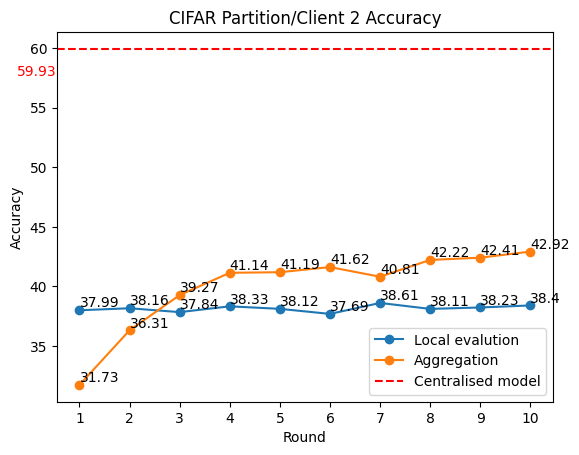

In [19]:
#plt.plot(iteration,Train_acc_result,marker='o',label="Train")
plt.title(f"CIFAR Partition/Client {NumOfPartition} Accuracy")
plt.plot(iteration,Val_acc_result,marker='o',label="Local evalution")
plt.plot(iteration,Test_acc_result,marker='o',label="Aggregation")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.xticks(iteration)

for i, j in zip(iteration, Val_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')
for i, j in zip(iteration, Test_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')

average_value = 59.93
plt.gca().text(0, average_value/68, f"{average_value}", transform=plt.gca().transAxes, ha='right',color='r',)
plt.axhline(y=average_value, color='r', linestyle='--', label='Centralised model')

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.legend()

plt.show()